# 遭遇了巨大的问题，API模型没有办法在训练过程中输出中间的结果！
# 目前我创建了两个网络，让他们一个输出最后，一个输出上一层参数，两个网络权重共享。
# 已经解决，只需要做一个多输出模型即可，输出好几个结果，用的时候不需要的话就把另外一个结果用_,不输出

In [1]:
import tensorflow as tf
import numpy as np
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
class PolicyGradient:
    def __init__(
        self,
        n_actions,
        n_features,
        learning_rate=0.01,
        reward_decay=0.95
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        
        #PG的memory不是利用一个数组存放的数据。而是利用了三个列表分别存储observation， action， reward
        self.ep_obs, self.ep_as, self.ep_rs =[],[],[]
        
        self._build_net()  #这里相当于是把pg_net也定义了,也定义了all_acts
        
    def make_model(self):
        #建立网络
        tf_obs = tf.keras.layers.Input(shape=(self.n_features,), name='observation')
        x = tf.keras.layers.Dense(10, activation='tanh', name='fc1')(tf_obs)
        all_acts = tf.keras.layers.Dense(self.n_actions, name='fc2')(x)  #输出中间结果
        all_acts_prob = tf.keras.layers.Softmax()(all_acts)
        pg_net = tf.keras.Model(inputs=tf_obs, outputs=[all_acts_prob, all_acts]) #PG_net返回两个值，一个是最终，一个是上一层
        
        return pg_net
        
    def _build_net(self):
        '''建立策略网络，不是值网络了！'''
        self.pg_net = self.make_model()
        #优化器
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
 
    def choose_action(self, observation):
        '''根据observation来选择动作'''
        # 输入一个状态到网络，得到这个状态下，几个动作对应的被选中的概率。[1, n_actions]
        #由于返回两个值，第二个用占位符
        prob_weights, _ = self.pg_net(np.expand_dims(observation, axis=0))  #输入需要给observation添加一个维度,s输出转成np
        prob_weights = prob_weights.numpy()

        action = np.random.choice(range(prob_weights.shape[1]), p=prob_weights.ravel())  #展开这个概率数组，按照概率对动作进行选择，选出一个动作！
                #比如有10个动作，那么这个是0,1,2...9  #没有输入选几个默认选一个  #概率也有10个
        return action
    
    def store_transition(self, s, a, r):
        '''存储三个列表'''
        self.ep_obs.append(s)  #s列表
        self.ep_as.append(a)   #a列表
        self.ep_rs.append(r)   #r列表
        
    def learn(self):
        '''学习'''
        discounted_ep_rs_norm = self._discount_and_norm_rewards()  #返回了折扣之后的r数组
        
        # 训练,在这里应该直接输入实体变量
        with tf.GradientTape() as tape:
            _, all_act = self.pg_net(np.vstack(self.ep_obs))
            #损失函数之前写错了。tf.nn.sparse_softmax_cross_entropy_with_logits并不是keras.losses里的Sparse损失！
            neg_log_prob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=all_act, labels=np.array(self.ep_as)) 
            #计算损失
            self.loss = tf.reduce_mean(neg_log_prob * discounted_ep_rs_norm)  #reward guided loss
        
        #计算梯度
        gradients = tape.gradient(self.loss, self.pg_net.trainable_variables)
        #优化器优化梯度
        self.optimizer.apply_gradients(zip(gradients, self.pg_net.trainable_variables))
        
        self.ep_obs, self.ep_as, self.ep_rs = [],[],[]    #重置 episode data
        
        return discounted_ep_rs_norm   #返回一下reward的值
              
        
    def _discount_and_norm_rewards(self):
        '''折扣rewards,并且归一化rewards'''
        #折扣rewards
        discounted_ep_rs = np.zeros_like(self.ep_rs)
        running_add = 0
        for t in reversed(range(0, len(self.ep_rs))):
            running_add = running_add * self.gamma + self.ep_rs[t]
            discounted_ep_rs[t] = running_add
        
        #归一化rewards
        discounted_ep_rs -= np.mean(discounted_ep_rs)
        discounted_ep_rs /= np.std(discounted_ep_rs)
        return discounted_ep_rs

In [3]:
import gym
import matplotlib.pyplot as plt

# 训练模型

Discrete(3)
Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
[0.6  0.07]
[-1.2  -0.07]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

episode: 0   reward: -39306
episode: 1   reward: -38987
episode: 2   reward: -38728
episode: 3   reward: -38421
episode: 4   reward: -38176
episode: 5   reward: -37865
episode: 6   reward: -37610
episode: 7   reward: -37279
episode: 8   reward: -36971
episode: 9   reward: -36692
episode: 10   reward: -36380
episode: 11   reward: -36092
episode: 12   reward: -35756
episode: 13   reward: -35443
episode: 14   

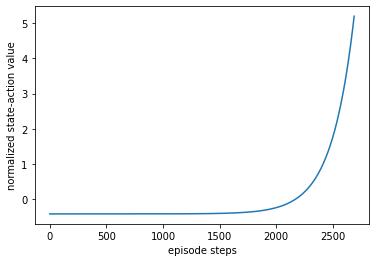

episode: 31   reward: -30180
episode: 32   reward: -29896
episode: 33   reward: -29627
episode: 34   reward: -29367
episode: 35   reward: -29098
episode: 36   reward: -28836
episode: 37   reward: -28588
episode: 38   reward: -28353
episode: 39   reward: -28110
episode: 40   reward: -27875
episode: 41   reward: -27615
episode: 42   reward: -27397
episode: 43   reward: -27151
episode: 44   reward: -26900
episode: 45   reward: -26677
episode: 46   reward: -26420
episode: 47   reward: -26169
episode: 48   reward: -25930
episode: 49   reward: -25687
episode: 50   reward: -25463
episode: 51   reward: -25229
episode: 52   reward: -25014
episode: 53   reward: -24788
episode: 54   reward: -24568
episode: 55   reward: -24346
episode: 56   reward: -24130
episode: 57   reward: -23906
episode: 58   reward: -23681
episode: 59   reward: -23473
episode: 60   reward: -23253
episode: 61   reward: -23039
episode: 62   reward: -22841
episode: 63   reward: -22632
episode: 64   reward: -22434
episode: 65   

episode: 312   reward: -3333
episode: 313   reward: -3305
episode: 314   reward: -3278
episode: 315   reward: -3248
episode: 316   reward: -3222
episode: 317   reward: -3196
episode: 318   reward: -3186
episode: 319   reward: -3165
episode: 320   reward: -3148
episode: 321   reward: -3144
episode: 322   reward: -3120
episode: 323   reward: -3112
episode: 324   reward: -3105
episode: 325   reward: -3093
episode: 326   reward: -3084
episode: 327   reward: -3064
episode: 328   reward: -3047
episode: 329   reward: -3030
episode: 330   reward: -3007
episode: 331   reward: -2984
episode: 332   reward: -2960
episode: 333   reward: -2942
episode: 334   reward: -2921
episode: 335   reward: -2906
episode: 336   reward: -2884
episode: 337   reward: -2868
episode: 338   reward: -2855
episode: 339   reward: -2840
episode: 340   reward: -2824
episode: 341   reward: -2808
episode: 342   reward: -2797
episode: 343   reward: -2796
episode: 344   reward: -2780
episode: 345   reward: -2776
episode: 346  

In [4]:
DISPLAY_REWARD_THRESHOLD = -2000  # renders environment if total episode reward is greater then this threshold
RENDER = False  # rendering wastes time

env = gym.make('MountainCar-v0')
env.seed(1)     # reproducible, general Policy gradient has high variance
env = env.unwrapped

print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

RL = PolicyGradient(
    n_actions=env.action_space.n,
    n_features=env.observation_space.shape[0],
    learning_rate=0.02,
    reward_decay=0.995
)

for i_episode in range(1000):

    observation = env.reset()

    while True:
        if RENDER: env.render()

        action = RL.choose_action(observation)

        observation_, reward, done, info = env.step(action)

        RL.store_transition(observation, action, reward)

        if done: #回合制学习，只有done了才学习一次
            ep_rs_sum = sum(RL.ep_rs)

            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
            if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True     # rendering
            print("episode:", i_episode, "  reward:", int(running_reward))

            vt = RL.learn()

            if i_episode == 30:
                plt.plot(vt)    # plot the episode vt
                plt.xlabel('episode steps')
                plt.ylabel('normalized state-action value')
                plt.show()
            break
        observation = observation_

        
        
#设置目标分数，够了就保存模型
    if running_reward >=-1000:
        break
RL.pg_net.save_weights('pg_weights_mountaincar.h5')


# 测试训练好的模型

In [4]:
env = gym.make('MountainCar-v0')

RL_test = PolicyGradient(
    n_actions=env.action_space.n,
    n_features=env.observation_space.shape[0]
)


In [5]:
RL_test.pg_net.load_weights('pg_weights_mountaincar.h5')

In [13]:
for i_episode in range(20):

    observation = env.reset()

    while True:
        env.render()

        action = RL_test.choose_action(observation)

        observation_, reward, done, info = env.step(action)
        
        RL_test.store_transition(observation, action, reward)  #为了显示reward，需要加上去这一句，如果不想显示这个reward，可以不加

        if done:
            ep_rs_sum = sum(RL_test.ep_rs)

            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
            print("episode:", i_episode, "  reward:", int(running_reward))
            

        observation = observation_
        

episode: 0   reward: -6483
episode: 0   reward: -6589
episode: 0   reward: -6693
episode: 0   reward: -6797
episode: 0   reward: -6899
episode: 0   reward: -7001
episode: 0   reward: -7101
episode: 0   reward: -7200
episode: 0   reward: -7299
episode: 0   reward: -7396
episode: 0   reward: -7493
episode: 0   reward: -7588
episode: 0   reward: -7683
episode: 0   reward: -7777
episode: 0   reward: -7869
episode: 0   reward: -7961
episode: 0   reward: -8052
episode: 0   reward: -8142
episode: 0   reward: -8231
episode: 0   reward: -8319
episode: 0   reward: -8407
episode: 0   reward: -8493
episode: 0   reward: -8579
episode: 0   reward: -8664
episode: 0   reward: -8748
episode: 0   reward: -8831
episode: 0   reward: -8913
episode: 0   reward: -8995
episode: 0   reward: -9075
episode: 0   reward: -9155
episode: 0   reward: -9234
episode: 0   reward: -9313
episode: 0   reward: -9390
episode: 0   reward: -9467
episode: 0   reward: -9543
episode: 0   reward: -9618
episode: 0   reward: -9693
e

episode: 0   reward: -16700
episode: 0   reward: -16706
episode: 0   reward: -16712
episode: 0   reward: -16719
episode: 0   reward: -16725
episode: 0   reward: -16731
episode: 0   reward: -16737
episode: 0   reward: -16743
episode: 0   reward: -16749
episode: 0   reward: -16755
episode: 0   reward: -16761
episode: 0   reward: -16767
episode: 0   reward: -16772
episode: 0   reward: -16778
episode: 0   reward: -16784
episode: 0   reward: -16789
episode: 0   reward: -16795
episode: 0   reward: -16801
episode: 0   reward: -16806
episode: 0   reward: -16812
episode: 0   reward: -16817
episode: 0   reward: -16822
episode: 0   reward: -16828
episode: 0   reward: -16833
episode: 0   reward: -16838
episode: 0   reward: -16843
episode: 0   reward: -16849
episode: 0   reward: -16854
episode: 0   reward: -16859
episode: 0   reward: -16864
episode: 0   reward: -16869
episode: 0   reward: -16874
episode: 0   reward: -16879
episode: 0   reward: -16883
episode: 0   reward: -16888
episode: 0   reward:

episode: 0   reward: -17504
episode: 0   reward: -17505
episode: 0   reward: -17506
episode: 0   reward: -17507
episode: 0   reward: -17509
episode: 0   reward: -17510
episode: 0   reward: -17511
episode: 0   reward: -17512
episode: 0   reward: -17514
episode: 0   reward: -17515
episode: 0   reward: -17516
episode: 0   reward: -17517
episode: 0   reward: -17519
episode: 0   reward: -17520
episode: 0   reward: -17521
episode: 0   reward: -17522
episode: 0   reward: -17524
episode: 0   reward: -17525
episode: 0   reward: -17526
episode: 0   reward: -17527
episode: 0   reward: -17528
episode: 0   reward: -17530
episode: 0   reward: -17531
episode: 0   reward: -17532
episode: 0   reward: -17533
episode: 0   reward: -17535
episode: 0   reward: -17536
episode: 0   reward: -17537
episode: 0   reward: -17538
episode: 0   reward: -17539
episode: 0   reward: -17541
episode: 0   reward: -17542
episode: 0   reward: -17543
episode: 0   reward: -17544
episode: 0   reward: -17545
episode: 0   reward:

episode: 0   reward: -17841
episode: 0   reward: -17842
episode: 0   reward: -17843
episode: 0   reward: -17844
episode: 0   reward: -17845
episode: 0   reward: -17846
episode: 0   reward: -17847
episode: 0   reward: -17848
episode: 0   reward: -17849
episode: 0   reward: -17850
episode: 0   reward: -17851
episode: 0   reward: -17852
episode: 0   reward: -17853
episode: 0   reward: -17854
episode: 0   reward: -17855
episode: 0   reward: -17856
episode: 0   reward: -17858
episode: 0   reward: -17859
episode: 0   reward: -17860
episode: 0   reward: -17861
episode: 0   reward: -17862
episode: 0   reward: -17863
episode: 0   reward: -17864
episode: 0   reward: -17865
episode: 0   reward: -17866
episode: 0   reward: -17867
episode: 0   reward: -17868
episode: 0   reward: -17869
episode: 0   reward: -17870
episode: 0   reward: -17871
episode: 0   reward: -17872
episode: 0   reward: -17873
episode: 0   reward: -17874
episode: 0   reward: -17875
episode: 0   reward: -17876
episode: 0   reward:

KeyboardInterrupt: 